In [2]:
# Import relevant python packages
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
%matplotlib inline

## Donor RFM Scoring & Segmentation 

In [ ]:
# Load the CSV files into DataFrames 
donors_df = pd.read_csv('donor_behavioral_features.csv', header = 0)
transactions_df = pd.read_csv('transactions_processed.csv', header = 0)

### RFM Quantile-Based Scoring
> In this section, we build donor segments and compute RFM (**Recency-Frequency-Monetary**) scores for **monthly donors**.
> - **Initial Segmentation:** RFM scoring is applied only to monthly donors. **One-time donors** and **non-monthly recurring donors** are instead placed into separate categories: `one_time` and `rec_not_monthly`.
> - **Recency scoring (R-score):** Monthly donors are classified as **engaged, lapsed, or churned** (3, 2, or 1) by comparing their `recency` to **1.5x their median donation interval**.
> - **Frequency & Monetary scoring (F-score, M-score):** Monthly donors are binned into quartiles using **25th/50th/75th percentiles** to assign scores from 1-4.
> - **Final RFM score:** For monthly donors, `rfm_score = r_score + f_score + m_score`, then merged back into the main DataFrame. 

In [26]:
# ----------------------------------------------------------------
# INITIAL SEGMENT LABELING BASED ON RECURRING STATUS
# ----------------------------------------------------------------

# Start with no segment label
donors_df['segment'] = None

# One-time donors
one_time_mask = ~donors_df['is_recurring']
donors_df.loc[one_time_mask, 'segment'] = 'one_time'

# Recurring but not monthly
rec_not_monthly_mask = donors_df['is_recurring'] & ~donors_df['is_monthly']
donors_df.loc[rec_not_monthly_mask, 'segment'] = 'rec_not_monthly'

# Keep a mask and subset for monthly donors
monthly_mask = donors_df['is_monthly']
monthly_df = donors_df.loc[monthly_mask]

# ----------------------------------------------------------------
# R-SCORE (RECENCY) FOR MONTHLY DONORS
# Rule: recency relative to 1.5 * median donation interval
# ----------------------------------------------------------------

donors_df['r_score'] = None # initialize as blank

interval = donors_df['median_recent_interval']
recency = donors_df['recency']

# Classify fully engaged monthly donors (not lapsed or churned)
donors_df.loc[monthly_mask & (recency < 1.5*interval), 'r_score'] = 3

# Classify monthly donors who have lapsed in their giving
donors_df.loc[monthly_mask & (recency >= 1.5*interval) & (recency <= 120), 'r_score'] = 2

# Classify monthly donors who have churned (considered to be lost)
donors_df.loc[monthly_mask & (recency >= 120), 'r_score'] = 1

# ----------------------------------------------------------------
# BUILD QUANTILE BINS FOR FREQUENCY & MONETARY (MONTHLY DONORS)
# ----------------------------------------------------------------

def compute_bins(df, feature):
    # Compute quartile-based bins for a feature
    # Returns: [0, 25%, 50%, 75%, inf]
    q1, q2, q3 = df[feature].quantile([0.25, 0.50, 0.75])
    return [0, q1, q2, q3, np.inf]

# Compute bins for monthly donors (monthly_df)
frequency_bins = compute_bins(monthly_df, 'frequency')
monetary_bins = compute_bins(monthly_df, 'monetary')

# ----------------------------------------------------------------
# ASSIGN F-SCORE & M-SCORE USING QUARTILE BINS
# ----------------------------------------------------------------

# Initialize scores 
donors_df[['f_score', 'm_score']] = None

# Compute frequency scores
donors_df.loc[monthly_mask, 'f_score'] = pd.cut(monthly_df['frequency'], bins = frequency_bins, labels = [1, 2, 3, 4])

# Compute monetary scores
donors_df.loc[monthly_mask, 'm_score'] = pd.cut(monthly_df['monetary'], bins = monetary_bins, labels = [1, 2, 3, 4])

# ----------------------------------------------------------------
# MERGE RFM SCORES FOR MONTHLY DONORS TO MAIN DATAFRAME
# ----------------------------------------------------------------

# Reassign monthly_df with mask 
monthly_df = donors_df.loc[monthly_mask]

donors_df = donors_df.merge(
    # Create rfm_score vectorized and keep only donor_name + rfm_score
    monthly_df.assign(
        rfm_score = lambda df: df['r_score'].astype('str') + df['f_score'].astype('str') + df['m_score'].astype('str')
    )[['donor_name', 'rfm_score']],
    on = 'donor_name', how = 'left'   
)

### Assigning Donor Segments Using RFM Scores
>We assign donor segments **only for monthly donors** by applying **regular expression rules** to their **RFM score** (Recency, Frequency, Monetary), and specific patterns are mapped to meaningful behavioral segments.
>
>**Monthly Donor Segments:**
>- `champions`: Fully engaged monthly donors with the highest frequency and monetary value.
>- `loyal_donors`: Fully engaged monthly donors who give frequently but with moderate monetary amounts.
>- `big_spenders`: Fully engaged monthly donors who give large amounts but have not yet reached high donation frequency.
>- `lapsed`: Monthly donors whose giving has slowed relative to their historical cadence, but who have not fully churned.
>- `churned`: Monthly donors who have not given for an extended period and are considered disengaged.
>
>**Additional Handling:**
>- Monthly donors whose RFM scores do not match any of the above patterns are labeled `other`.
>- **Non-monthly recurring donors** and **one-time donors** retain their previously assigned segments (`rec_not_monthly`, `one_time`) and are excluded from RFM-based segmentation.

In [27]:
# Define a segmentation map using regular expressions and RFM scores
seg_map = {
    r'2[1-4][1-4]': 'lapsed', # Monthly donors who have lapsed in their giving but not fully churned -- 1.5x median_recent_interval < recency < 120 
    r'1[1-4][1-4]': 'churned', # Monthly donors who have churned (considered to be lost or fully unengaged) -- 120 < recency 
    r'3[1-2]4': 'big_spenders', # Monthly donors who are engaged & give large amounts but have not yet given frequently -- potential champions
    r'3[3-4][1-3]': 'loyal_donors', # Monthly donors who are engaged, have given the most frequently, but not as generously as champions
    r'[3]44': 'champions' # Monthly donors who are engaged, have given the most frequently and most monetary -- most valuable donors
}

# Reassign monthly_df with mask 
monthly_df = donors_df.loc[monthly_mask]

# Segment donors according to seg_map, adding easily identifiable lables (e.g., 'lapsed')
donors_df.loc[monthly_mask, 'segment'] = monthly_df['rfm_score'].replace(seg_map, regex = True)

# All donors who do not fall into the aforementioned categories will be labeled as 'other'
donors_df.loc[~donors_df['segment'].isin(list(seg_map.values()) + ['rec_not_monthly', 'one_time']), 'segment'] = 'other'

# Quick summary of RFM scores and segments
donors_df[['segment', 'r_score', 'f_score', 'm_score', 'rfm_score']].describe()

,segment,r_score,f_score,m_score,rfm_score
count,139,103,103,103,103
unique,8,3,4,4,27
top,churned,3,1,2,344
freq,32,68,41,26,17


> This segmentation strategy is adapted from the article:
> [Customer Segmentation with RFM Analysis using Python](https://medium.com/@gurkanc/customer-segmentation-with-rfm-analysis-using-python-8ba043252d33)

## Donor Segmentation Overview & Insights

### Donor Segment Behavior Analysis
> To better understand donor behavior after RFM scoring, we used bar plots to summarize:
> - The **number of donors** in each segment.
> - The corresponding **total donation value** of each segment.

In [ ]:
# Initialize figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (15, 8)) 

# Alphabetically order the segments for consistency in visuals 
ordered_segments = sorted(donors_df['segment'].unique())

# Count plot for donor segments 
sns.countplot(data = donors_df, x = 'segment', palette = palette, ax = ax[0], order = ordered_segments)
ax[0].set_xticklabels(labels = ordered_segments, rotation = 45, ha = 'center')
ax[0].set_xlabel('Donor Segment', fontsize = 16)
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].set_title('Number of Donors Per Segment', fontsize = 20, fontweight = 'bold')

# Compute the total amount in donations per donor segment 
segment_monetary = donors_df.groupby('segment', as_index = False).agg({'monetary' : 'sum'})

# Bar plot for total donations per segment
sns.barplot(data = segment_monetary, x = 'segment', y = 'monetary', palette = palette, ax = ax[1], order = ordered_segments)
ax[1].set_xticklabels(labels = ordered_segments, rotation = 45, ha = 'center')
ax[1].set_xlabel('Donor Segment', fontsize = 16)
ax[1].set_ylabel('Amount (USD)', fontsize = 16)
ax[1].set_title('Total Donations Per Segment', fontsize = 20, fontweight = 'bold')

fig.tight_layout()
plt.savefig('donor_segmentation.png')

> **Number of Donors per Segment**:
>- This count plot shows how many donors fall into each segment.
>- Most donors belong to the `churned` category, followed by `other`, suggesting that a large portion of the donor base is **either no longer engaged or does not exhibit clear behavioral patterns captured by the current segmentation**.
>  
> **Total Donations per Segment**:
>- This bar plot highlights the **total monetary contribution** of each segment.
>- The majority of donations come from `champions`, followed by `churned`, suggesting that while the `one-time` and `other` groups are large, `champions` remain **the most financially impactful**.

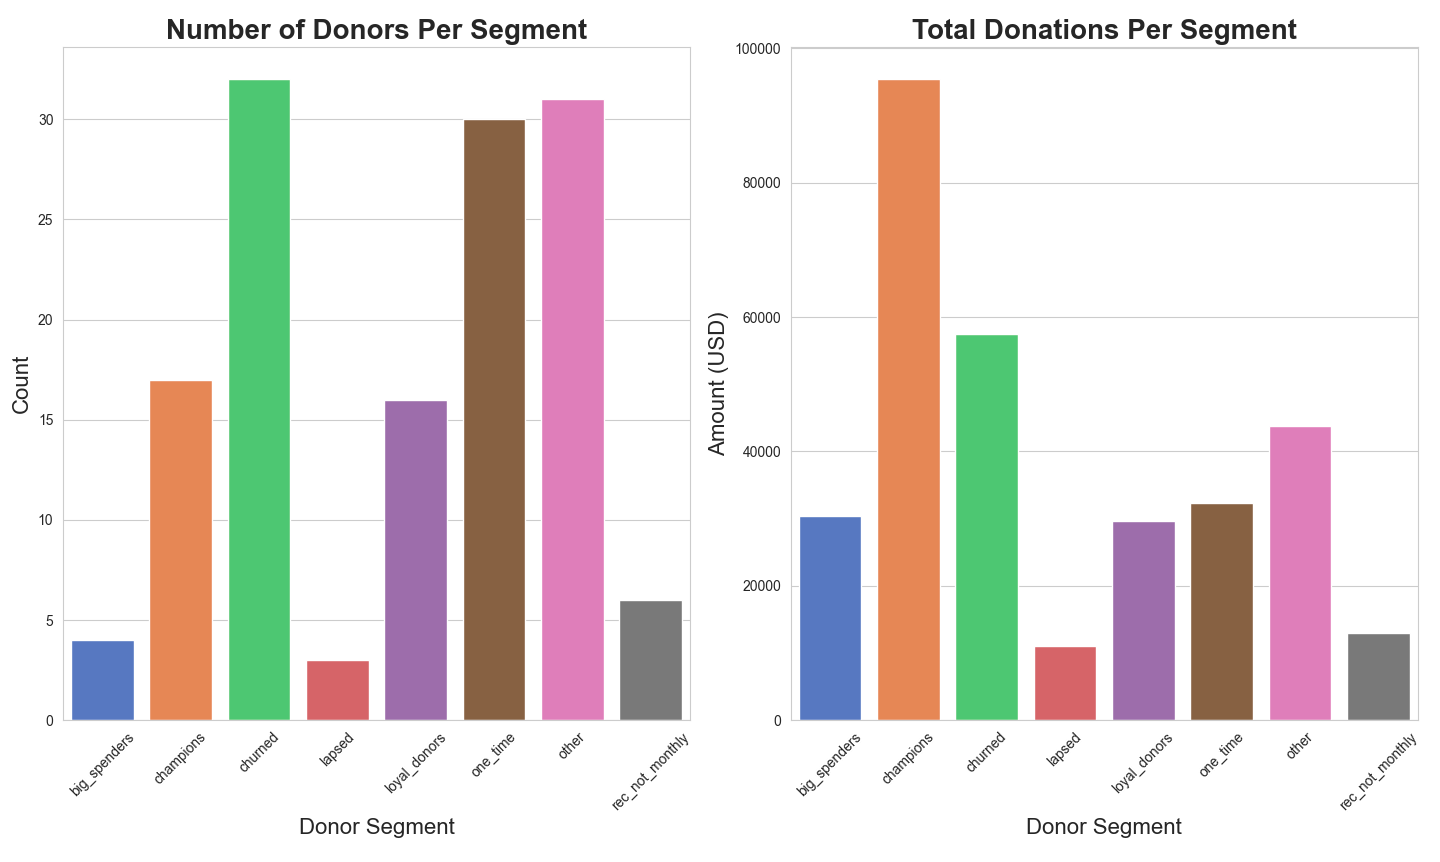

### Donor Segmentation by State: Arizona, Texas, & Colorado
>To explore how **donor behavior varies geographically**, we generated a heatmap showing the **number of donors in each segment across three key states** (containing the highest volume of donors across all states): Arizona (AZ), Texas (TX), and Colorado (CO).
>
>Each cell shows the donor count for a specific segment and state combination.

In [ ]:
# Filter for states of interest
target_states_df = donors_df[donors_df['state'].isin(['AZ', 'TX', 'CO'])]

# Group by state & donor segment, and compute the number of donors
segment_counts_by_state = (
    target_states_df
        .groupby(['state', 'segment'])
        .agg(**{'donor_counts': ('donor_name', 'count')})
)

# Pivot donor_counts for heatmap format
segment_counts_pivot = segment_counts_by_state.unstack(fill_value = 0)

# Determine x-axis labels 
segments = sorted(donors_df['segment'].unique())

# Initialize figure 
fig = plt.figure(figsize = (15, 8))

# Heat map for donor count by State & segment 
sns.heatmap(
    data = segment_counts_pivot, cmap = 'vlag', 
    annot = True, linecolor = 'black', xticklabels = segments, 
    linewidths = 0.5, cbar_kws = {'label': 'Donor Count'}
)
plt.title('Donor Segment Distribution Across States', fontsize = 20, fontweight = 'bold')
plt.xlabel('Donor Segment', fontsize = 16)
plt.ylabel('State', fontsize = 16)

plt.savefig('segment_heatmap_updated.png')

> This visualization illustrates the geographic distribution of donor segments, highlighting regions with a strong presence of high-value donors (champions, loyal_donors) as well as areas where re-engagement efforts may be needed (lapsed, churned).
> - **Arizona** contains the highest number of donors across several segments, including `champions`, `loyal_donors`, `one_time`, and `churned`, indicating **a broad mix of both highly engaged and fully disengaged donors**.
> - **Colorado** shows a relatively balanced distribution across segments, indicating a **symmetric but less concentrated donor base**.
> - **Texas** is dominated by the `other` segment, indicating the need for **a more robust segmentation or additional analysis** to better understand donor behavior in that state.
>
> Overall, Arizona stands out as both the largest donor market and the state with the greatest concentration of high-value donors, alongside a substantial group of donors who may benefit from targeted re-engagement efforts. For in-person fundraising initiatives in the U.S., this suggests an opportunity to both celebrate and retain `champions` while strategically reactivating `churned` donors.

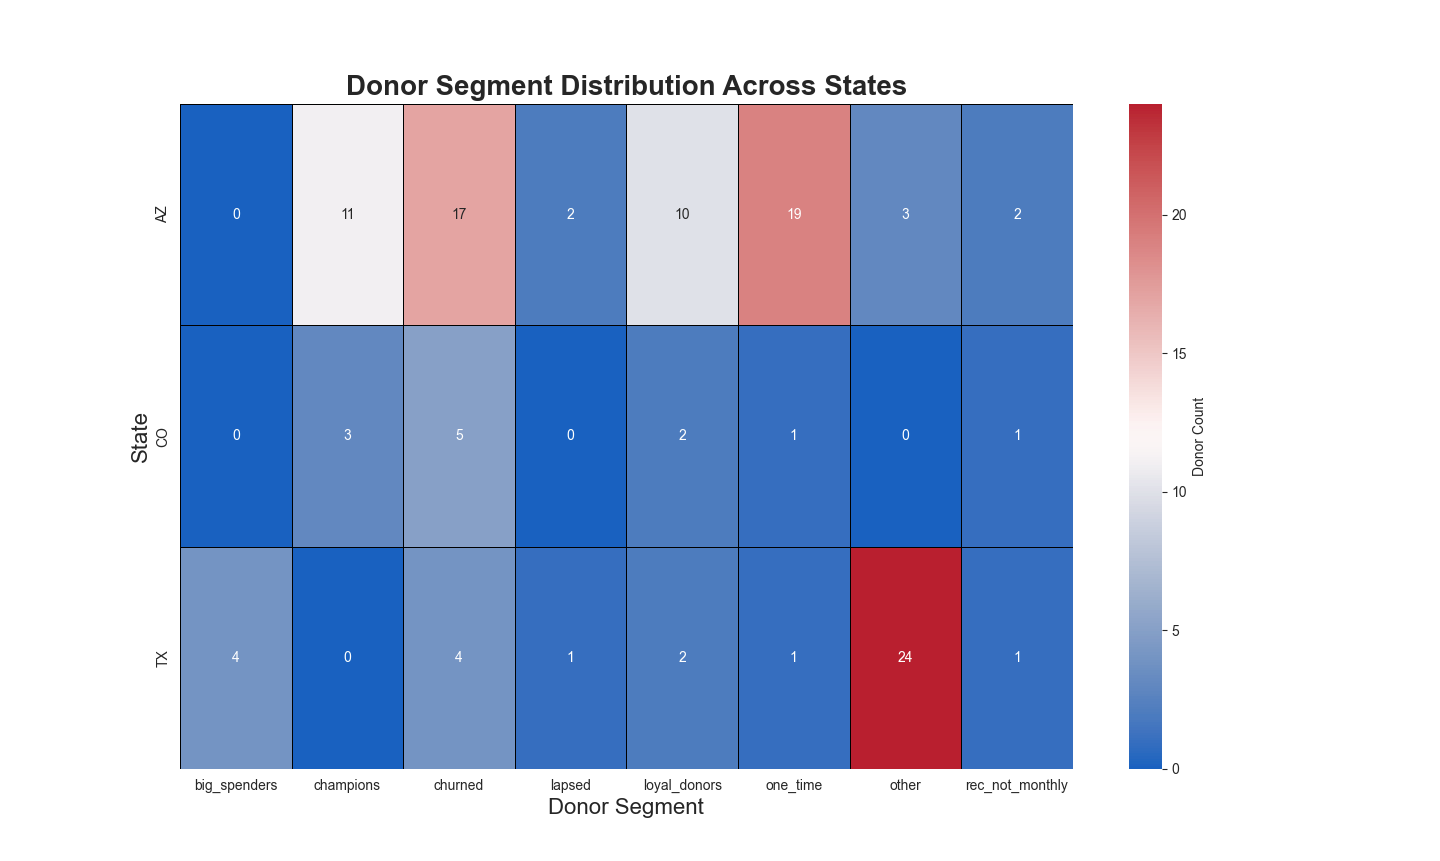

### Median Donation Amount Distributions by Segment
>In this section, we visualize and compare the distribution of donors’ **median gift amounts** across all **donor segments**.
Because donation amounts are typically **right-skewed**, the x-axis is plotted on a **logarithmic scale**, which makes differences between segments easier to interpret.
>
>This KDE plot helps highlight:
>- Which segments tend to give higher amounts
>- Overlap between donor groups
>- Whether certain segments have distinct giving patterns
>
> These distributions should be interpreted as **indicative rather than definitive**, as the segment-level **sample sizes are relatively small** (the largest segment has fewer than 35 donors).

In [ ]:
# Initialize figure 
fig = plt.figure(figsize = (15, 8))

# Plot KDE of median donation amounts by donor segment
# use log-scale to handle skewed donation amounts
sns.kdeplot(
	data = donors_df, x = 'med_amount', hue = 'segment', 
	fill = True, palette = palette, log_scale = True 
)
plt.title('Median Donation Distributions by Segment', fontsize = 20, fontweight = 'bold')
plt.xlabel('Median Donation Amount (Log Scale)', fontsize = 16)
plt.ylabel('Density', fontsize = 16)

plt.savefig('segment_median_amounts_udpated.png')

>**Median Donation Distributions by Segment:**
>- The `champions`, `lapsed`, `churned`, and `other` segments show substantial **distribution overlap**, with very **similar central tendencies**.
>- The `churned` and `other` segments exhibit nearly **identical standard deviations**, indicating that donors in these groups display **similar giving patterns**.
>- Although the **central tendencies are comparable**, the `champions` and `lapsed` segments have noticeably **smaller standard deviations** than the `churned` and `other` groups. This may be due to **smaller sample sizes**, which naturally produce less variability.
>- The `big_spenders` segment has a clearly **right-shifted distribution**, confirming the expectation that these donors give **larger amounts** relative to other groups.
>- The `one_time` donor distribution shows a **broad range of giving amounts**, with noticeable density peaks around **100 and 1,000 dollars**.

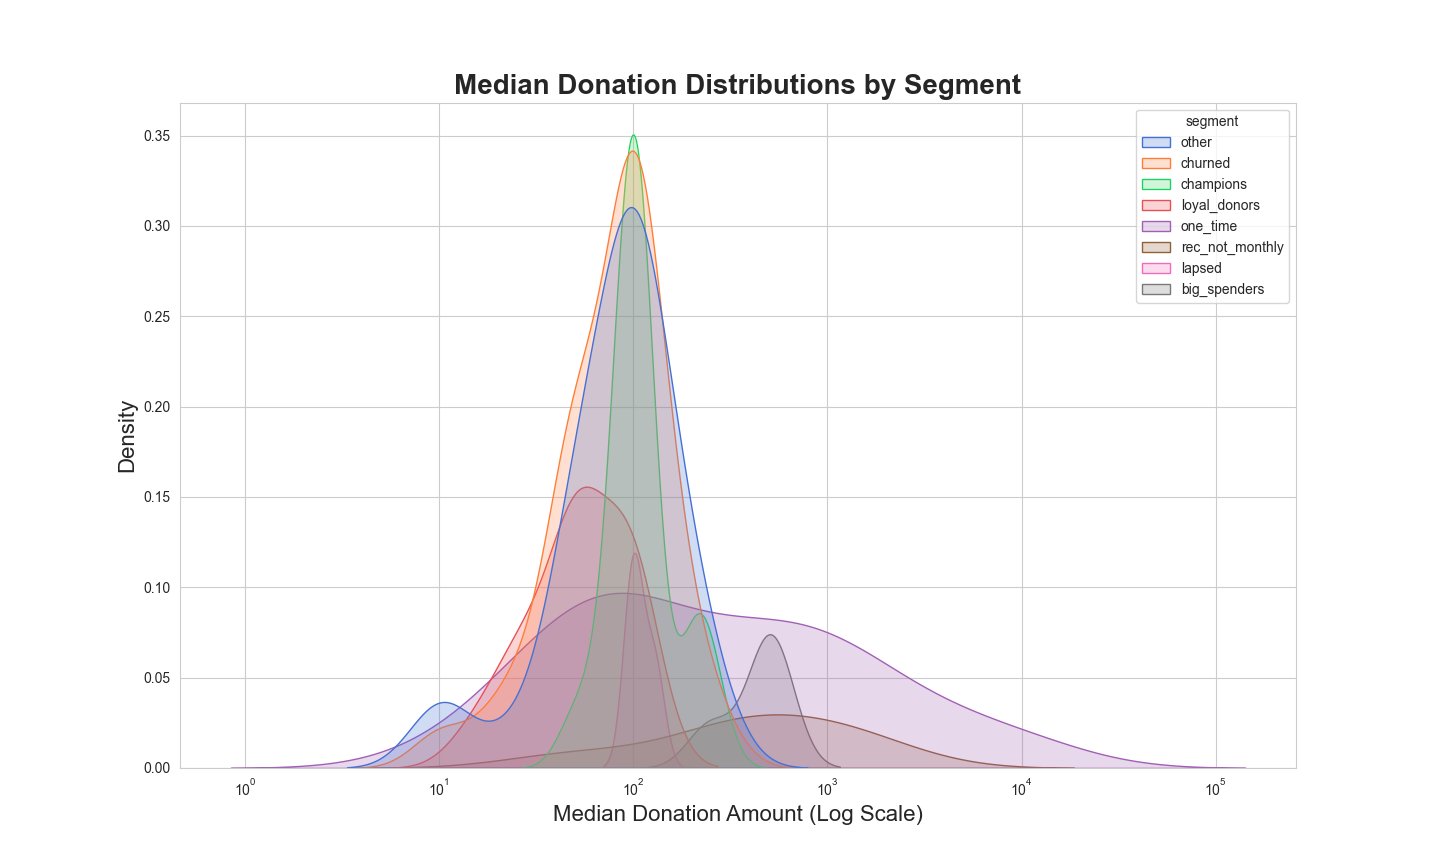

In [ ]:
# Save the final donor DataFrame to CSV file
donors_df.to_csv('donor_segmentation_rfm.csv', index = False)